# Fitting a simple model: Logistic growth

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We have created a dataset in the previous notebook, now it is time to use some data to fit a model. <br>
A complete definition of a fitting problem consists of 

1. Data 
2. Parameters
3. Simulation
4. A fitting routine (calibration algorithm + additional analysis steps)

In the subdirectory `logistic_growth`, we have an example of how these ingredients can be arranged into Python scripts. 

You could use this as a template for other fitting problems. 

The convention of `mempyfit` is that `fitting_problem.py` A fitting problem `prob`, 
which can be solved using the `solve()` method. <br>
The results are then reported using the `report()` method.

Fitted model using Nelder-Mead method.

#### ---- Estimated parameters ---- ####

{'r': np.float64(0.13919802962383548), 'K': np.float64(0.2412039616593094)}

### ---- Visual check ---- ####


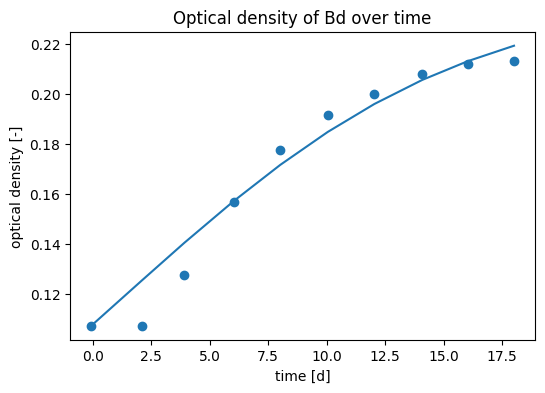

In [3]:
from logistic_growth.fitting_problem import prob
sol = prob.solve()
report = sol.report()

In the following, we take a deeper look into what is happening in the template files. <br>

If you have ever used something like [AmP tool](https://amptool.debtheory.org/docs/), this will look somewhat familiar, but there are important differences.

## Defining the data

The definition of the data works in the same way as we have learned in the previous notebook. <br>
Here, we just have single entry, ,which is optical density of the fungus *Batrachochytrium dendrobatidis* over time, or `t-OD`. <br>
The data was taken from [Voyles et al. (2017)](https://link.springer.com/article/10.1007/s00442-017-3866-8). Optical density here is a proxy for population density.

In [4]:
from mempyfit import *
data = Dataset()

data.add(
    name = 't-OD', 
    # we can add values here or (better) read the from files
    value = np.array([
        [ -0.05911330049261121,0.10723981900452495],
        [2.0886699507389164,0.10723981900452495],
        [3.9211822660098505,0.12760180995475118],
        [6.029556650246304,0.15656108597285068],
        [8.019704433497536,0.1773755656108597],
        [10.049261083743838,0.19140271493212674],
        [12.039408866995073,0.2],
        [14.088669950738913,0.20769230769230773],
        [16.039408866995075,0.21176470588235297],
        [18.00985221674877,0.21312217194570138]
    ]), 
    units = ['d', '-'], 
    labels = ['time', 'optical density'],
    title = 'Optical density of Bd over time',
    bibkey = 'voylesDiversityGrowthPatterns2017' #  we can add a bibkey from Zotero to document literature sources 
)


We can have a quick look at the data using the `plot` function. <br>
This does not produce publication-ready plots, but is rather intended as a quick way to inspect and internally report the data.

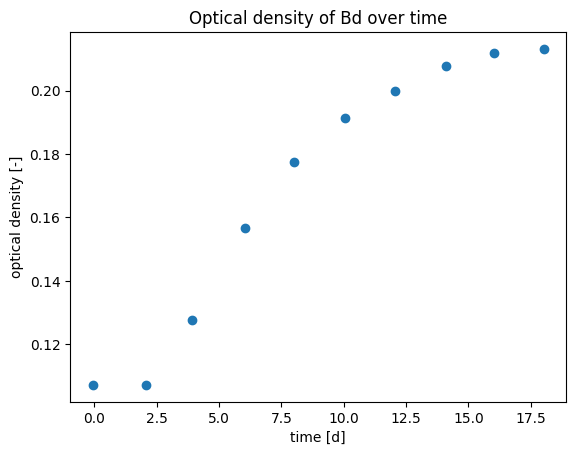

In [5]:
fig, ax = prob.data.plot('t-OD')

## Defining the parameters

Next, we are defining parameters. <br>
This is done by instantiating an instance of the class `Parameters`, 
which also comes from `mempyfit`.

In [6]:
from mempyfit import Parameters

parameters = Parameters({
            'r' : {'value' : 0.2, 'free' : True, 'unit' : 'd^-1', 'label' : 'growth rate'}, 
            'K' : {'value' : 1.0, 'free' : True, 'unit' : '-', 'label' : 'carrying capacity'},
        })

We have two entries, `r` and `K`, which are the parameters of the logistic growth model. <br>
Let's have a look at how we specified 'r':

```Python
'r' : {'value' : 0.2, 'free' : True, 'unit' : 'd^-1', 'label' : 'growth rate'}
```

Each parameter is entered as a dictionary, which has the fields:

- `value`: The default value we assign. Fitting routines may use these as starting points.
- `free`: Whether we want to estimate the parameter, or fix it to `value`.
- `unit`: Unit of the parameter - only relevant for reporting purposes.
- `label`: A brief description, also for reporting purposes.

Here, we could extend the list with an arbitrary number of parameters, keeping some fixed and others free.

## Defining the simulator

The simulator defines how we get from a set of parameter values to the corresponding simulation. <br>
We start by defining our core model, the logistic growth model, as ODE system.

In [7]:
from logistic_growth.data import *
from logistic_growth.parameters import *
from scipy.integrate import solve_ivp
from mempyfit import Dataset
  
def dNdt(t, y, p: dict):
    """
    Definition of the log-logistic ODE. 

    - t: Time point. In most cases this is not used, but scipy expects it to be part of the ODE definition.
    - y: State variables. These are always stored in an array, but can be "unpacked" at the beginning of the ODE definition.
    - p: Parameters. The syntax below implies that parameters are stored in a dictionary, which improves readability compared to a list or array.
    """
    
    N = y[0] # unpacking state variables

    return p['r']*N*(1-(N/p['K'])) 

We can use `p['r]` and `p['K']` because the `Parameters` class has been told to return `value` when we try to use it like a dictionary:

In [8]:
parameters['r']

np.float64(0.13919802962383548)

Next we might define some additional quantities that are needed during the simulation. In this case, the time span that we need to simulate:

In [9]:
tmin = np.min(data['t-OD'][:,0])
tmax = np.max(data['t-OD'][:,0])+1

The simulation has to have the same form as the data. In this case, a `Dataset`. <br>
The actual `simulator` function wraps around our core model and makes sure that that is the case.

In [10]:
def simulator(parameters):

    """
    Simulate the logistic growth model.

    args:
    -p: a dictionary with proposed parameter values

    kwargs:
    -t_eval: time-points to be evaluated by the ODE solver. By default, the unique time-points in a globally defined data frame called `data`
    """
    
    sim_dataset = data.empty_like()
    y0 = [data['t-OD'][0,1]] # initial conditions for the ODE

    sim = solve_ivp(    
        dNdt,
        (tmin, tmax), 
        y0,
        args = (parameters,),
        t_eval = data['t-OD'][:,0] 
    )

    sim_array = np.array([sim.t, sim.y[0]]).transpose()
    
    # Return as Dataset to match expected format
    sim_dataset['t-OD'] = sim_array

    return sim_dataset


The `Dataset` class has a method `empty_like`, that allows us to create a `Dataset` instance that has the same shape as our original dataset, but the actual values are not filled in yet.

## Defining the fittig problem

Now we are ready to put everything together, which is done in `fitting_problem.py`. <br>

At the beginning of this file, you see a statement like this, 

```Python
from .data import *
from .parameters import *
from .simulation import *
```

which means that we gather the information from the other files. <br>

Next, we have a class definition.

In [11]:
from mempyfit import FittingProblem
from mempyfit import ScipyBackend

class LogisticFit(FittingProblem):
    """
    This defines the logistic fitting problem as a custom class, 
    which inherits from the generic `FittingProblem`. 
    Instantiating it will assign the data defined in `data.py`, 
    the parameters defined in `parameters.py` 
    and the simulator defined in `simulator.py`. 

    We can instatiate it like so:
    
    ```Python
    prob = LogisticFit()
    ```

    To solve the problem, we can do

    ```Python 
    sol = prob.solve()
    ```
    
    """

    def __init__(self):
        super().__init__()
        self.data = data
        self.parameters = parameters
        self.simulator = simulator
        self.define_loss()


    def solve(self, Backend = ScipyBackend, method = 'Nelder-Mead', **kwargs):
        backend = Backend(self)
        backend.run(method = method, **kwargs)

        return backend

The statement  `LogisticFit(FittingProblem)` means that we are creating a sub-class of the generic `FittingProblem` class. This class is specific to our type of problem, i.e. fitting a logistig growth model. 

When we do `prob = LogisticFit()`, this will execute

```Python
super().__init__()
self.data = data
self.parameters = parameters
self.simulator = simulator
self.define_loss()
```

The `super().__init__()` means that everything that is done for the initialization of the generic `FittingProblem` will also be done for our `LogisticFit` problem. 

Then we assign data, parameters and simulator to our class as we have defined them in the other files. <br>

Remember that this is just a template to get started. 
We could total add additional arguments to `__init__(self)` to assign these fields in a more dynamic and generic way. 

At the end of `fitting_problem.py` we have:

In [12]:
from logistic_growth.data import * # additional imports needed in the notebook
from logistic_growth.parameters import *
from logistic_growth.simulation import *

prob = LogisticFit()

This materializes the `LogisticFit` problem which we had already solved at the very beginning of this notebook, using

Fitted model using Nelder-Mead method.

#### ---- Estimated parameters ---- ####

{'r': np.float64(0.13919802962383548), 'K': np.float64(0.2412039616593094)}

### ---- Visual check ---- ####


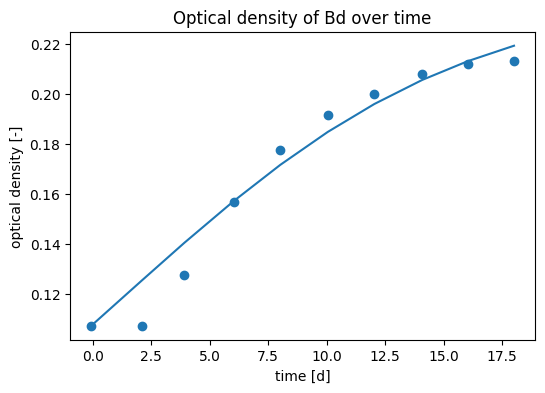

In [13]:
sol = prob.solve()
report = sol.report()

We can also use a different method to do the fitting, e.g. Powell's method:

Fitted model using Powell method.

#### ---- Estimated parameters ---- ####

{'r': np.float64(0.13920187439199266), 'K': np.float64(0.24119834486267588)}

### ---- Visual check ---- ####


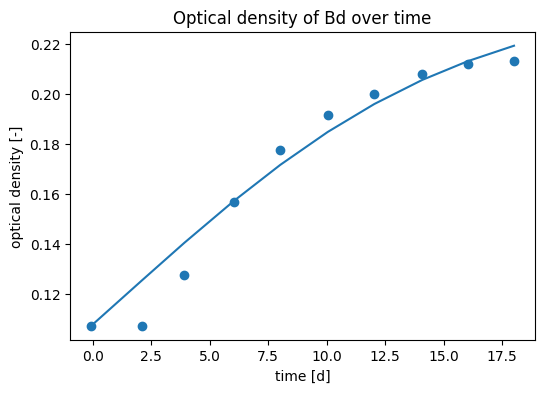

In [14]:
sol = prob.solve(method = 'Powell')
report = sol.report()

In this case, we get practically identical results, but this will not always be the case. 

We can also perform global optimization using differential evolution. 
For this, we need to specifiy non-finite parameter boundaries. <br>
This option was not taken into account in the `solve` method we had defined for the `LogisticFit` class, but it is not much work to add it *ad hoc*:

Fitted model using differential_evolution method.

#### ---- Estimated parameters ---- ####

{'r': np.float64(0.13919053166350573), 'K': np.float64(0.24119871121421252)}

### ---- Visual check ---- ####


{'estimates': {'r': np.float64(0.13919053166350573),
  'K': np.float64(0.24119871121421252)},
 'figure': (<Figure size 600x400 with 1 Axes>,
  array([<Axes: title={'center': 'Optical density of Bd over time'}, xlabel='time [d]', ylabel='optical density [-]'>],
        dtype=object))}

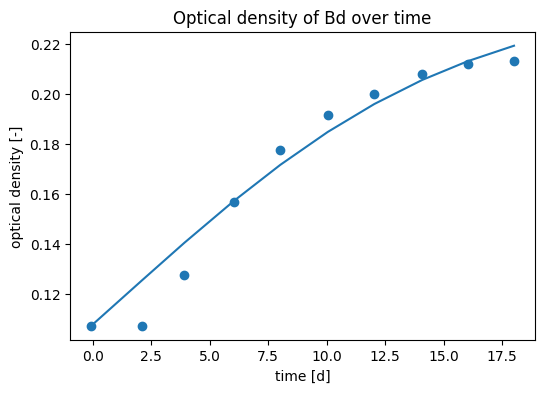

In [15]:
sol.bounds = optimize.Bounds(lb = [0, 0], ub = [10, 20])
sol.run(method = 'differential_evolution')
sol.report()

Again, we have practically identical results, increasing our confidence that the estimates we have identified previously are global optima.